# Jason's Tesla Data Analysis (Quarantine Personal Project 2020) 

## Cleaning the data and making pandas dataframes

In [61]:
#import libraries
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from datetime import datetime,timedelta
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression

#ignore python warnings and full width
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:90% !important; }</style>"))

#get all csv file names
filepath='/Users/jasontan/Documents/IPYNB/Tesla_csv'
all_files = glob.glob(filepath + "/*.csv")

#put all csv file names into a list
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

#concatenate all csv files into a dataframe
df = pd.concat(li, axis=0)

#changing columns
df=df[df['Electric Distance Fraction (%)']==100]#only interested in 100% electric distances (some values are 0 for no travel)
df.drop(columns=['Gasoline Consumed (gal)','Electric Distance Fraction (%)'], inplace=True) #because this column is all NaN
df=df[df['Distance (mi)']>=0.1]#only interested in data where the car traveled more than 0.1 mile
df=df[df['Electric Driving Efficiency (Wh/mi)']>0]#exclude data that has a negative efficiency
df.rename(columns={'Auxiliary Load (kWh)':'Non-Moving Electricity Consumed (kWh)','Electricity Consumed (kWh)':'Total Electricity Consumed (kWh)'}, inplace=True)
df['Moving Electricity Consumed (kWh)']=df['Total Electricity Consumed (kWh)']-df['Non-Moving Electricity Consumed (kWh)']

#reset the row-index
df.index= range(df['Start Date'].shape[0])

#format the start date
for i in range(0,df['Start Date'].shape[0]):
    df['Start Date'][i] = df['Start Date'][i][:-12]
    df['Start Date'][i]=datetime.strptime((df['Start Date'][i]),'%m/%d/%Y')
    
#correct speed column
df['Duration']=pd.to_timedelta(df['Duration'])
df['Duration (hours)']=np.nan
df['Average Speed (mph)']=np.nan
for i in range (0,df['Duration'].shape[0]):
    df['Average Speed (mph)'][i] = (df['Distance (mi)'][i])/((df['Duration'][i].seconds)/3600)
    df['Duration (hours)'][i]=(df['Duration'][i].seconds)/3600

#group data by start date
df=df.groupby(['Start Date']).mean()

#remove low speed travels
df=df[df['Average Speed (mph)']>=5]

#correct the column forumlas
df['Electric Driving Efficiency (Wh/mi)']=(1000*(df['Moving Electricity Consumed (kWh)']))/(df['Distance (mi)'])
df['Delta SOC']=(df['Starting SOC (%)']-df['Ending SOC (%)'])/100
df['Battery Size Estimate (kWh)']=df['Total Electricity Consumed (kWh)']/df['Delta SOC']
df['Fuel Efficiency Equivalent (MPGeq)']=36650/df['Electric Driving Efficiency (Wh/mi)']

#remove outliers
Q1=df.quantile(.25)
Q3=df.quantile(.75)
IQR=Q3-Q1
df=df[df>Q1-1.5*IQR]
df=df[df<Q3+1.5*IQR]

#drop missing values
df.dropna(inplace=True)

#re-order columns
df=df.reindex(columns=['Total Electricity Consumed (kWh)',
                       'Moving Electricity Consumed (kWh)',
                       'Non-Moving Electricity Consumed (kWh)',
                       'Distance (mi)',
                       'Electric Driving Efficiency (Wh/mi)',
                       'Fuel Efficiency Equivalent (MPGeq)',
                       'Starting SOC (%)',
                       'Ending SOC (%)',
                       'Delta SOC',
                       'Duration (hours)',
                       'Average Speed (mph)',
                       'Smooth Acceleration (%)',
                       'Smooth Braking (%)',
                       'Ambient Temperature (F)',
                       'Battery Size Estimate (kWh)'])

#print averages
print('The average Distance per trip is ',df['Distance (mi)'].mean(),'miles')
print('The average Electricity Consumed per trip is ',(df['Moving Electricity Consumed (kWh)']).mean(),'kWh')
print('The average Efficiency per trip is ',df['Electric Driving Efficiency (Wh/mi)'].mean(),'Wh/mi')
print('The average Efficiency per overall is ',((1000*df['Moving Electricity Consumed (kWh)'].sum())/df['Distance (mi)'].sum()),'Wh/mi')
print('The average Temperature overall when driving is ',df['Ambient Temperature (F)'].mean(),'F')
print('The average Speed per trip is ',df['Average Speed (mph)'].mean(),'mph')

The average Distance per trip is  4.902673454609119 miles
The average Electricity Consumed per trip is  1.5752836930226632 kWh
The average Efficiency per trip is  342.55852799476486 Wh/mi
The average Efficiency per overall is  321.31115963713705 Wh/mi
The average Temperature overall when driving is  54.18576059969443 F
The average Speed per trip is  14.802805254044875 mph


## Pandas DataFrame

In [62]:
#select the important columns for future analysis
df_temp=df.loc[:,['Electric Driving Efficiency (Wh/mi)','Ambient Temperature (F)']]
df_smooth=df.loc[:,['Electric Driving Efficiency (Wh/mi)','Smooth Acceleration (%)','Smooth Braking (%)']]
df_speed=df.loc[:,['Electric Driving Efficiency (Wh/mi)','Average Speed (mph)']]
df_battery=df.loc[:,['Electric Driving Efficiency (Wh/mi)','Battery Size Estimate (kWh)']]
df

,Total Electricity Consumed (kWh),Moving Electricity Consumed (kWh),Non-Moving Electricity Consumed (kWh),Distance (mi),Electric Driving Efficiency (Wh/mi),Fuel Efficiency Equivalent (MPGeq),Starting SOC (%),Ending SOC (%),Delta SOC,Duration (hours),Average Speed (mph),Smooth Acceleration (%),Smooth Braking (%),Ambient Temperature (F),Battery Size Estimate (kWh)
Start Date,,,,,,,,,,,,,,,
2019-09-08,2.940000,2.811250,0.128750,10.750000,261.511628,140.146732,85.681250,79.487500,0.061937,0.390729,16.388412,68.893750,67.292500,76.550000,47.467205
2019-09-10,0.325000,0.305000,0.020000,1.045000,291.866029,125.571311,68.920000,68.235000,0.006850,0.087778,11.888942,40.570000,56.095000,75.200000,47.445255
2019-09-12,0.585000,0.495000,0.090000,1.065000,464.788732,78.853030,67.190000,65.980000,0.012100,0.142778,7.896597,74.675000,69.700000,70.700000,48.347107
2019-09-14,1.645714,1.497143,0.148571,5.887143,254.307207,144.117032,77.050000,73.585714,0.034643,0.361706,11.120359,73.664286,73.861429,74.942857,47.505155
2019-09-18,0.716667,0.600000,0.116667,1.653333,362.903226,100.991111,63.360000,61.813333,0.015467,0.121019,10.961072,47.470000,52.230000,63.800000,46.336207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-04,1.025000,0.695000,0.330000,2.440000,284.836066,128.670504,57.055000,54.695000,0.023600,0.356250,7.460291,52.620000,66.720000,77.900000,43.432203
2020-06-05,0.895000,0.680000,0.215000,2.430000,279.835391,130.969853,50.755000,48.760000,0.019950,0.323194,8.929548,66.900000,71.290000,73.400000,44.862155
2020-06-06,1.235000,1.115000,0.120000,4.560000,244.517544,149.886996,45.665000,42.830000,0.028350,0.287639,16.344829,73.245000,77.555000,83.300000,43.562610


## Correlation Coefficients between columns

In [63]:
#Correlation of efficiency vs other columns
eff=np.corrcoef(df.T)[4]
corr=pd.Series(eff)
corr.index=df.columns
abs_corr=abs(corr)
sorted_index= np.array(abs_corr.sort_values(ascending=False).index)
sorted_corr=corr.reindex(index=sorted_index)
sorted_corr

Electric Driving Efficiency (Wh/mi)      1.000000
Fuel Efficiency Equivalent (MPGeq)      -0.975061
Ambient Temperature (F)                 -0.514557
Duration (hours)                        -0.362968
Distance (mi)                           -0.362364
Smooth Acceleration (%)                 -0.306419
Smooth Braking (%)                      -0.260137
Non-Moving Electricity Consumed (kWh)    0.255428
Moving Electricity Consumed (kWh)       -0.165673
Battery Size Estimate (kWh)              0.136438
Delta SOC                               -0.128729
Total Electricity Consumed (kWh)        -0.127200
Starting SOC (%)                        -0.116719
Ending SOC (%)                          -0.088580
Average Speed (mph)                     -0.032487
dtype: float64

## Correlation Matrix

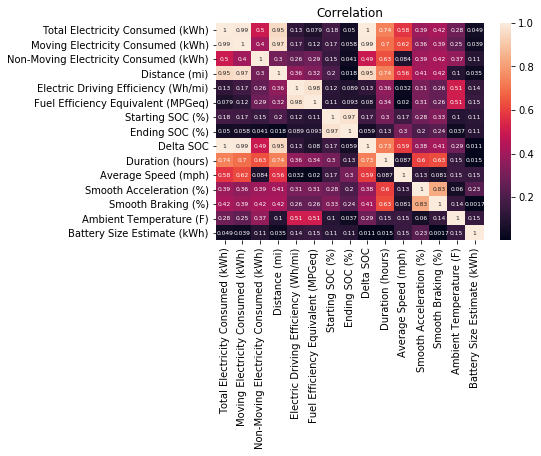

In [64]:
#plotting
corrMatrix = abs(df.corr())
sn.heatmap(corrMatrix, annot=True,annot_kws={"size":6})
title='Correlation'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

## Compare Efficiency and Temperature over time

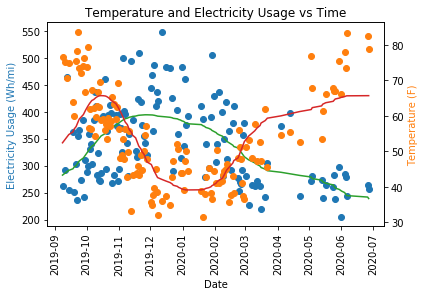

In [65]:
#get variables
time=df_temp.index
efficiency=df_temp['Electric Driving Efficiency (Wh/mi)'].values
temp=(df_temp['Ambient Temperature (F)'].values)

#crerating two subplots
fig, e = plt.subplots()

#first plot
color = 'tab:blue'
e.set_xlabel('Date')
e.set_ylabel('Electricity Usage (Wh/mi)', color=color)
plt.xticks(rotation=90)
e.plot(time, efficiency, 'o',color=color)

#second plot
color = 'tab:orange'
t = e.twinx()
t.set_ylabel('Temperature (F)', color=color)
t.plot(time, temp, 'o', color=color)

#polynomial of best fit
x=range(time.shape[0])
def func(x, a, b, c):
    return a * np.sin(b * x) + c
xdata=x
ye_data=efficiency
yt_data=temp
e_opt, e_cov = curve_fit(func, xdata, ye_data,bounds=(0, [200, .1, 500]))
t_opt, t_cov = curve_fit(func, xdata, yt_data,bounds=(0, [100, .1, 100]))
y_e=np.ones(shape=time.shape[0])
y_t=np.ones(shape=time.shape[0])
for i in x:
    y_e[i]=func(x[i], *e_opt)
    y_t[i]=func(x[i], *t_opt)
e.plot(time, y_e, color='tab:green')
t.plot(time, y_t, color='tab:red')

#plotting
plt.tight_layout()
title='Temperature and Electricity Usage vs Time'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

## Correlation between Efficiency and Temperature

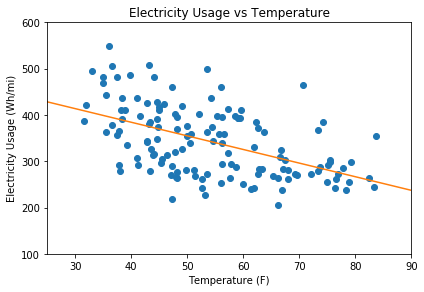

The correlation between Efficiency and Temperature is -0.5145570910801527


In [66]:
#get variables
efficiency=df_temp['Electric Driving Efficiency (Wh/mi)'].values
temp=(df_temp['Ambient Temperature (F)'].values)

#ploting
plt.plot(temp,efficiency,'o')

#line of best fit
a,b = np.polyfit(temp, efficiency, 1)
y=np.ones(shape=time.shape[0])
x= range(temp.shape[0])
for i in x:
    y[i]=a*x[i]+b    
plt.plot(x,y)

#plotting
plt.xlabel('Temperature (F)')
plt.ylabel('Electricity Usage (Wh/mi)')
plt.xlim(25,90)
plt.ylim(100,600)
plt.tight_layout()
title='Electricity Usage vs Temperature'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

#correlation
print('The correlation between Efficiency and Temperature is',np.corrcoef(efficiency,temp)[0][1])

## Comparing Speed and Effciency over time

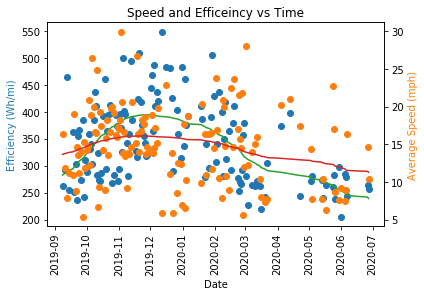

In [67]:
#get variables
time=df_speed.index
speed=df_speed['Average Speed (mph)']
efficiency=df_speed['Electric Driving Efficiency (Wh/mi)']

#creating two subplots
fig, e = plt.subplots()

#first plot
color = 'tab:blue'
e.set_xlabel('Date')
e.set_ylabel('Efficiency (Wh/mi)', color=color)
plt.xticks(rotation=90)
e.plot(time, efficiency, 'o',color=color)

#second plot
color = 'tab:orange'
sp = e.twinx()
sp.set_ylabel('Average Speed (mph)', color=color)
sp.plot(time, speed, 'o', color=color)

#polynomial of best fit
def func(x, a, b, c):
    return a * np.sin(b * x) + c
xdata=x
ye_data=efficiency
e_opt, e_cov = curve_fit(func, xdata, ye_data,bounds=(0, [200, .1, 500]))
f,g,h = np.polyfit(x, speed, 2)
y_e=np.ones(shape=time.shape[0])
y_sp=np.ones(shape=time.shape[0])
for i in x:
    y_e[i]=func(x[i], *e_opt)
    y_sp[i]=f*x[i]**2+g*x[i]+h
e.plot(time, y_e, color='tab:green')
sp.plot(time, y_sp, color='tab:red')

#plotting
plt.tight_layout()
title='Speed and Efficeincy vs Time'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

## Correlation between Efficiency and Speed

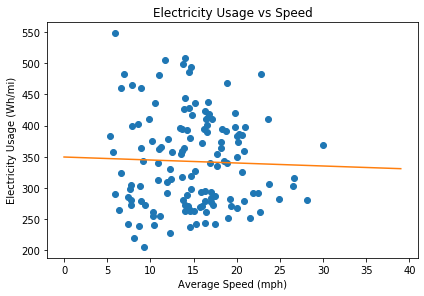

The correlation between Electricity Usage and Speed is -0.03248709508376455


In [68]:
#get variables
time=df_speed.index
speed=df_speed['Average Speed (mph)']
efficiency=df_speed['Electric Driving Efficiency (Wh/mi)']

#plotting
plt.plot(speed,efficiency,'o')

#line of best fit
a,b = np.polyfit(speed, efficiency, 1)
y=np.ones(shape=40)
x= range(40)
for i in x:
    y[i]=a*x[i]+b    
plt.plot(x,y)

#plotting
plt.xlabel('Average Speed (mph)')
plt.ylabel('Electricity Usage (Wh/mi)')
plt.tight_layout()
title='Electricity Usage vs Speed'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

#correlation
print('The correlation between Electricity Usage and Speed is',np.corrcoef(efficiency,speed)[0][1])

## Comparing Smoothness and Effciency over time

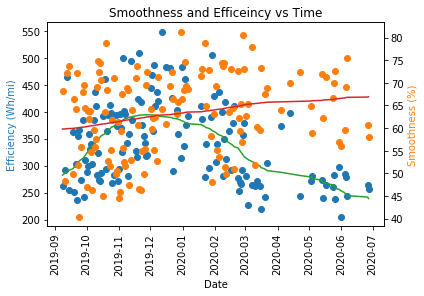

In [69]:
#get variables
time=df_smooth.index
smooth=df_smooth.iloc[:,1:]
smooth['Smooth']=(smooth['Smooth Acceleration (%)']+smooth['Smooth Braking (%)'])/2
smooth=smooth.iloc[:,-1].values
efficiency=df_smooth['Electric Driving Efficiency (Wh/mi)']

#creating two subplots
fig, e = plt.subplots()

#first plot
color = 'tab:blue'
e.set_xlabel('Date')
e.set_ylabel('Efficiency (Wh/mi)', color=color)
plt.xticks(rotation=90)
e.plot(time, efficiency, 'o',color=color)

#second plot
color = 'tab:orange'
sm = e.twinx()
sm.set_ylabel('Smoothness (%)', color=color)
sm.plot(time, smooth, 'o', color=color)

#polynomial of best fit
x=range(time.shape[0])
def func(x, a, b, c):
    return a * np.sin(b * x) + c
xdata=x
ye_data=efficiency
e_opt, e_cov = curve_fit(func, xdata, ye_data,bounds=(0, [200, .1, 500]))
f,g,h = np.polyfit(x, smooth, 2)
y_e=np.ones(shape=time.shape[0])
y_sm=np.ones(shape=time.shape[0])
for i in x:
    y_e[i]=func(x[i], *e_opt)
    y_sm[i]=f*x[i]**2+g*x[i]+h
e.plot(time, y_e, color='tab:green')
sm.plot(time, y_sm, color='tab:red')

#plotting
plt.tight_layout()
title='Smoothness and Efficeincy vs Time'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

## Correlation between Efficiency and Smoothness

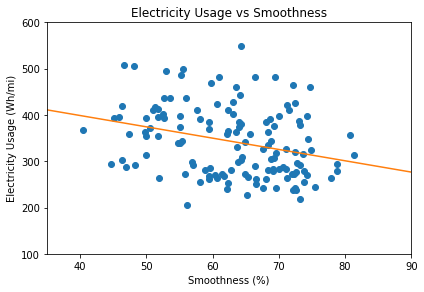

The correlation between Electricty Usage and Smoothness is -0.2961390225552342


In [70]:
#get variables
smooth=df_smooth.iloc[:,1:]
smooth['Smooth']=(smooth['Smooth Acceleration (%)']+smooth['Smooth Braking (%)'])/2
smooth=smooth.iloc[:,-1].values
efficiency=df_smooth['Electric Driving Efficiency (Wh/mi)']

#plotting
plt.plot(smooth,efficiency,'o')

#line of best fit
a,b = np.polyfit(smooth, efficiency, 1)
y=np.ones(shape=time.shape[0])
x= range(smooth.shape[0])
for i in x:
    y[i]=a*x[i]+b    
plt.plot(x,y)

#plotting
plt.xlabel('Smoothness (%)')
plt.ylabel('Electricity Usage (Wh/mi)')
plt.xlim(35,90)
plt.ylim(100,600)
plt.tight_layout()
title='Electricity Usage vs Smoothness'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()

#correlation
print('The correlation between Electricty Usage and Smoothness is',np.corrcoef(efficiency,smooth)[0][1])

## Battery Degradation over time

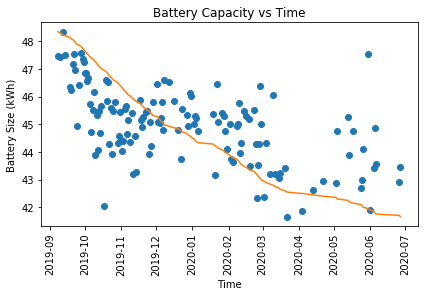

In [71]:
#get variables
time=df_battery.index
bat=df_battery['Battery Size Estimate (kWh)']

#plotting
fig, e = plt.subplots()
e.plot(time,bat,'o')

#line of best fit
x=range(time.shape[0])
a,b = np.polyfit(x,bat, 1)
y=np.ones(shape=time.shape[0])
for i in x:
    y[i]=a*x[i]+b
ba = e.twinx()
ba.plot(time,y, color='tab:orange')

#plotting
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
e.set_xlabel('Time')
e.set_ylabel('Battery Size (kWh)')
ba.axis('off')
plt.tight_layout()
title='Battery Capacity vs Time'
plt.title(title)
plt.savefig('img/'+title+'.png',dpi=500,bbox_inches = "tight")
plt.show()